In [15]:
from gensim.models import Word2Vec, KeyedVectors

import pandas as pd
import pandas_profiling
import numpy as np
np.set_printoptions(suppress=True, precision=3)
from datetime import datetime
import jieba
import re
import os

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import OneHotEncoder, scale, normalize, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, classification_report

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 8)
%matplotlib inline

# 数据加载

In [4]:
df = pd.read_csv('data/movie_comments.csv')

In [5]:
df.head()

,id,link,name,comment,star
0,1,https://movie.douban.com/subject/26363254/,战狼2,吴京意淫到了脑残的地步，看了恶心想吐,1
1,2,https://movie.douban.com/subject/26363254/,战狼2,首映礼看的。太恐怖了这个电影，不讲道理的，完全就是吴京在实现他这个小粉红的英雄梦。各种装备轮...,2
2,3,https://movie.douban.com/subject/26363254/,战狼2,吴京的炒作水平不输冯小刚，但小刚至少不会用主旋律来炒作…吴京让人看了不舒服，为了主旋律而主旋...,2
3,4,https://movie.douban.com/subject/26363254/,战狼2,凭良心说，好看到不像《战狼1》的续集，完虐《湄公河行动》。,4
4,5,https://movie.douban.com/subject/26363254/,战狼2,中二得很,1


In [6]:
df.describe()

,id,link,name,comment,star
count,261497,261497,261497,261495,261497
unique,260150,2761,2760,213970,11
top,9,https://movie.douban.com/subject/1849031/,当幸福来敲门 The Pursuit of Happyness,经典,4
freq,6,396,396,200,43002


# Helper Functions

In [7]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [8]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """对数损失度量（Logarithmic Loss  Metric）的多分类版本。
    :param actual: 包含actual target classes的数组
    :param predicted: 分类预测结果矩阵, 每个类别都有一个概率
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [19]:
# 评论的句子有点儿短，去掉一些停用词后可能丢失信息，试试不用停用词，简单去掉标点后分词
with open('data/stopwords.txt', 'r', encoding='utf-8') as f:
    STOPWORDS = set([line[:-1] for line in f.readlines()])

In [20]:
def clean_sentence_drop_stopwords(sentence):
    return list(set(jieba.cut(sentence)) - STOPWORDS)

In [64]:
def clean_sentence(sentence):
    result = []
    segment = re.findall('\d*\w+', sentence)
    result += [jieba.lcut(x) for x in segment]
    return [x for each in result for x in each if not x.isdigit()]

In [68]:
clean_sentence(df_new.comment[300])

['感人至深', '的', '电影']

In [48]:
a = ['首映礼', '看', '的']
b = ['首映礼', '看', '的']
a + b

['首映礼', '看', '的', '首映礼', '看', '的']

In [11]:
# trained_model
wiki_model_path = r"D:\Github\NLP\Artificial_Intelligence_for_NLP\Week_04_0727_word2vec\Assignment\word2vec_wiki.model"
wiki_model = Word2Vec.load(wiki_model_path)

In [12]:
# 使用句子中词汇的平均词向量作为句子词向量
def sentence_vector(sentence):
    flag = 0
    sentence_vec = np.zeros(wiki_model.vector_size)
    nums = len(sentence)
    for word in sentence:
        try:
            sentence_vec += wiki_model.wv[word]
            flag = 1
        except KeyError:
            nums -= 1
    return np.nan if not flag else sentence_vec / nums

# 预处理 

### star 属性应该只有1-5数字或者字符串选其一

In [13]:
df.star.unique()

array(['1', '2', '4', '5', '3', 'star', 4, 3, 5, 2, 1], dtype=object)

### 删除comment为nan行

In [14]:
df_new = df.copy()
df_new.drop(df_new[df_new.star=='star'].index, inplace=True)
df_new.dropna(subset=['comment'],inplace=True)
df_new.star = df_new.star.apply(lambda x: int(x))
df_new.reset_index(drop=True, inplace=True)
df_new.star.unique()

array([1, 2, 4, 5, 3], dtype=int64)

In [69]:
df_new['clean_comment'] = df_new.comment.apply(clean_sentence)

In [70]:
df_new['comment_vec'] = df_new.clean_comment.apply(sentence_vector)

In [71]:
df_new.tail()

,id,link,name,comment,star,clean_comment,comment_vec
261489,260145,https://movie.douban.com/subject/1441763/,不羁美少年 À cause d'un garçon,内容只能说一般。。女性角色怎么都这么悲催啊！！不过男猪脚很帅,3,"[内容, 只能, 说, 一般, 女性, 角色, 怎么, 都, 这么, 悲, 催, 啊, 不过...","[-0.9653091602958739, -0.5943305254913867, -0...."
261490,260146,https://movie.douban.com/subject/1441763/,不羁美少年 À cause d'un garçon,翘了三天班就窝在家里看小基片惹（手动拜拜.gif,3,"[翘, 了, 三天, 班, 就, 窝, 在, 家里, 看小, 基片, 惹, 手动, 拜拜, ...","[-0.1373161240057512, -0.9519095800139687, 1.0..."
261491,260147,https://movie.douban.com/subject/1441763/,不羁美少年 À cause d'un garçon,我喜欢女主角，希腊雕塑一般的面庞与身体。（在一部同志题材的电影中迷恋女主角好像很不应该吧）,2,"[我, 喜欢, 女主角, 希腊, 雕塑, 一般, 的, 面庞, 与, 身体, 在, 一部, ...","[-0.49309063826998073, -0.4821888374475141, -0..."
261492,260148,https://movie.douban.com/subject/1441763/,不羁美少年 À cause d'un garçon,冲着颜值还可以看下去,3,"[冲着, 颜值, 还, 可以, 看, 下去]","[-0.23062036807338396, -0.8813576425115267, -0..."
261493,260149,https://movie.douban.com/subject/1441763/,不羁美少年 À cause d'un garçon,除了主人公都不帅，女主挺漂亮之外……唯一的感觉就是他男朋友真让人恶心,3,"[除了, 主人公, 都, 不帅, 女主挺, 漂亮, 之外, 唯一, 的, 感觉, 就是, 他...","[-1.4769697139660518, 0.1903096747895082, -0.6..."


### 删除转化后comment_vec为nan的行

In [72]:
df_new.dropna(subset=['comment_vec'], inplace=True)
df_new.reset_index(drop=True, inplace=True)

In [73]:
df_new.tail()

,id,link,name,comment,star,clean_comment,comment_vec
250914,260145,https://movie.douban.com/subject/1441763/,不羁美少年 À cause d'un garçon,内容只能说一般。。女性角色怎么都这么悲催啊！！不过男猪脚很帅,3,"[内容, 只能, 说, 一般, 女性, 角色, 怎么, 都, 这么, 悲, 催, 啊, 不过...","[-0.9653091602958739, -0.5943305254913867, -0...."
250915,260146,https://movie.douban.com/subject/1441763/,不羁美少年 À cause d'un garçon,翘了三天班就窝在家里看小基片惹（手动拜拜.gif,3,"[翘, 了, 三天, 班, 就, 窝, 在, 家里, 看小, 基片, 惹, 手动, 拜拜, ...","[-0.1373161240057512, -0.9519095800139687, 1.0..."
250916,260147,https://movie.douban.com/subject/1441763/,不羁美少年 À cause d'un garçon,我喜欢女主角，希腊雕塑一般的面庞与身体。（在一部同志题材的电影中迷恋女主角好像很不应该吧）,2,"[我, 喜欢, 女主角, 希腊, 雕塑, 一般, 的, 面庞, 与, 身体, 在, 一部, ...","[-0.49309063826998073, -0.4821888374475141, -0..."
250917,260148,https://movie.douban.com/subject/1441763/,不羁美少年 À cause d'un garçon,冲着颜值还可以看下去,3,"[冲着, 颜值, 还, 可以, 看, 下去]","[-0.23062036807338396, -0.8813576425115267, -0..."
250918,260149,https://movie.douban.com/subject/1441763/,不羁美少年 À cause d'un garçon,除了主人公都不帅，女主挺漂亮之外……唯一的感觉就是他男朋友真让人恶心,3,"[除了, 主人公, 都, 不帅, 女主挺, 漂亮, 之外, 唯一, 的, 感觉, 就是, 他...","[-1.4769697139660518, 0.1903096747895082, -0.6..."


# Logistics Regression

In [74]:
X = np.array(df_new.comment_vec.tolist())
y = df_new.star
train_valid_X, test_X, train_valid_y, test_y = train_test_split(X, y, test_size=.2)
print('all datasets:\t\t', X.shape, y.shape)
print('train_valid_datasets:\t', train_valid_X.shape, train_valid_y.shape)
print('test_datasets:\t\t', test_X.shape, test_y.shape)

all datasets:		 (250919, 200) (250919,)
train_valid_datasets:	 (200735, 200) (200735,)
test_datasets:		 (50184, 200) (50184,)


In [75]:
log_clf = LogisticRegression()
log_clf.fit(train_valid_X, train_valid_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [77]:
ypred = log_clf.predict(train_valid_X)
print(classification_report(train_valid_y, ypred))

              precision    recall  f1-score   support

           1       0.40      0.23      0.29     19027
           2       0.32      0.02      0.04     21865
           3       0.37      0.33      0.35     50631
           4       0.37      0.70      0.49     64263
           5       0.43      0.23      0.30     44949

    accuracy                           0.38    200735
   macro avg       0.38      0.30      0.29    200735
weighted avg       0.38      0.38      0.34    200735



In [336]:
conf_mat = confusion_matrix(train_valid_y, ypred)

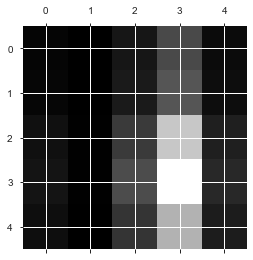

In [345]:
plt.matshow(conf_mat, cmap=plt.cm.gray)
plt.show()

In [348]:
sgd_clf = SGDClassifier()
sgd_clf.fit(train_valid_X, train_valid_y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [349]:
ypred_sgd = sgd_clf.predict(train_valid_X)
print(classification_report(train_valid_y, ypred_sgd))

              precision    recall  f1-score   support

           1       0.36      0.14      0.20     18575
           2       0.14      0.06      0.08     21340
           3       0.30      0.20      0.24     49131
           4       0.35      0.75      0.47     63113
           5       0.38      0.10      0.15     44113

    accuracy                           0.33    196272
   macro avg       0.30      0.25      0.23    196272
weighted avg       0.32      0.33      0.27    196272



# NeuralNetwork with TensorFlow

In [309]:
def log_dir(prefix=''):
    now = datetime.now().strftime('%Y%m%d_%H%M%S')
    root_logdir = 'tf_logs'
    if prefix:
        prefix += '-'
    name = prefix + 'run_' + now
    return os.path.join(root_logdir, name)


logdir = log_dir('douban_comment')

In [350]:
def train(train_flatten, train_labels, test_flatten, test_labels):
    reset_graph()
    checkpoint_path = 'tmp/douban_comment'
    units = 200
    initial_learning_rate = .1
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                                                                 decay_steps=10000,
                                                                 decay_rate=.96,
                                                                 staircase=True)

    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     monitor='val_acc',
                                                     verbose=1,
                                                     save_best_only=True,
                                                     load_weights_on_restart=True)
    stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc',
                                                     mode='max',
                                                     patience=3)
    csv_logger = tf.keras.callbacks.CSVLogger('csv_logger')
    tensorboard = tf.keras.callbacks.TensorBoard(logdir)

    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(4 * units, activation=tf.nn.relu, input_shape=(200, )),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(2 * units, activation=tf.nn.relu),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(units, activation=tf.nn.relu),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(5, activation=tf.nn.softmax)
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(lr_schedule),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(train_flatten, train_labels, validation_split=.2,
              epochs=100, batch_size=1024, callbacks=[cp_callback,
                                     stop_callback,
                                     csv_logger,
                                     tensorboard])

    print("Model's performance on test dataset:")
    print(f"Test accuracy: {model.evaluate(test_flatten, test_labels)[1] * 100:.3f}%")
    model.save('final_model.h5')

In [328]:
encoder = OneHotEncoder()
train_valid_y_1hot = encoder.fit_transform(train_valid_y.to_numpy().reshape(-1,1))
test_y_1hot = encoder.fit_transform(test_y.to_numpy().reshape(-1,1))
train_valid_y_1hot.shape, test_y_1hot.shape

((196272, 5), (49069, 5))

In [351]:
reset_graph()
train(train_valid_X, train_valid_y_1hot, test_X, test_y_1hot)

Train on 157017 samples, validate on 39255 samples
Epoch 1/100
156672/157017 [============================>.] - ETA: 0s - loss: 1.5631 - acc: 0.3093
Epoch 00001: val_acc improved from -inf to 0.31988, saving model to tmp/douban_comment
157017/157017 [==============================] - 11s 72us/sample - loss: 1.5629 - acc: 0.3093 - val_loss: 1.5183 - val_acc: 0.3199
Epoch 2/100
156672/157017 [============================>.] - ETA: 0s - loss: 1.5180 - acc: 0.3215
Epoch 00002: val_acc improved from 0.31988 to 0.31996, saving model to tmp/douban_comment
157017/157017 [==============================] - 11s 71us/sample - loss: 1.5180 - acc: 0.3215 - val_loss: 1.5156 - val_acc: 0.3200
Epoch 3/100
156672/157017 [============================>.] - ETA: 0s - loss: 1.5138 - acc: 0.3220- ETA: 1s - 
Epoch 00003: val_acc did not improve from 0.31996
157017/157017 [==============================] - 10s 63us/sample - loss: 1.5139 - acc: 0.3221 - val_loss: 1.5148 - val_acc: 0.3198
Epoch 4/100
156672/1570